In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from PIL import Image, UnidentifiedImageError
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
# Set random seed for reproducibility
torch.manual_seed(42)

# Define paths to dataset (adjust 'dataset' to your folder path)
train_dir = 'dataset/train'
validation_dir = 'dataset/validation'

# Image preprocessing transformations
IMG_SIZE = (64, 64)
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),  # Resize to 64x64
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert to tensor and normalize to [0, 1]
])

# Custom dataset to skip unidentifiable images
class SafeImageFolder(ImageFolder):
    def __getitem__(self, index):
        try:
            return super(SafeImageFolder, self).__getitem__(index)
        except UnidentifiedImageError:
            print(f"Skipping unidentifiable image: {self.samples[index][0]}")
            return None  # Return None for invalid images

# Custom collate function to filter None values
def safe_collate(batch):
    batch = [item for item in batch if item is not None]
    if len(batch) == 0:
        return None  # Return None if batch is empty
    return torch.utils.data.dataloader.default_collate(batch)

In [3]:
# Load datasets
train_dataset = SafeImageFolder(train_dir, transform=transform)
validation_dataset = SafeImageFolder(validation_dir, transform=transform)

# Create data loaders with custom collate
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=safe_collate)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=safe_collate)

In [4]:
class CatsDogsMLP(nn.Module):
    def __init__(self):
        super(CatsDogsMLP, self).__init__()
        self.flatten = nn.Flatten()  # Flatten 64x64x1 to 4096
        self.layer1 = nn.Linear(64 * 64 * 1, 512)  # Hidden layer 1: 4096 -> 512
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(512, 256)  # Hidden layer 2: 512 -> 256
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(256, 128)  # Hidden layer 3: 256 -> 128
        self.relu3 = nn.ReLU()
        self.output = nn.Linear(128, 1)  # Output layer: 128 -> 1
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)  # Shape: [batch, 4096]
        x = self.layer1(x)   # Shape: [batch, 512]
        x = self.relu1(x)
        x = self.layer2(x)   # Shape: [batch, 256]
        x = self.relu2(x)
        x = self.layer3(x)   # Shape: [batch, 128]
        x = self.relu3(x)
        x = self.output(x)   # Shape: [batch, 1]
        x = self.sigmoid(x)  # Shape: [batch, 1]
        return x

In [5]:
# Initialize model, loss function, and optimizer
model = CatsDogsMLP()
criterion = nn.BCELoss()  # Binary cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
NUM_EPOCHS = 10
train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    # Use tqdm for batch progress
    train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Train]')
    for batch in train_bar:
        if batch is None:  # Skip empty batches
            continue
        images, labels = batch
        images, labels = images, labels.float().view(-1, 1)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(images)  # Neuron calculations
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()  # Gradient calculations
        optimizer.step()
        
        running_loss += loss.item()
        train_bar.set_postfix({'loss': loss.item()})
    
    avg_train_loss = running_loss / len([b for b in train_loader if b is not None])
    train_losses.append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    val_bar = tqdm(validation_loader, desc=f'Epoch {epoch+1}/{NUM_EPOCHS} [Val]')
    with torch.no_grad():
        for batch in val_bar:
            if batch is None:
                continue
            images, labels = batch
            images, labels = images, labels.float().view(-1, 1)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            predicted = (outputs >= 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            val_bar.set_postfix({'val_loss': val_loss / (total / BATCH_SIZE)})
    
    avg_val_loss = val_loss / len([b for b in validation_loader if b is not None])
    val_losses.append(avg_val_loss)
    
    print(f'Epoch [{epoch+1}/{NUM_EPOCHS}], '
          f'Train Loss: {avg_train_loss:.4f}, '
          f'Val Loss: {avg_val_loss:.4f}, '
          f'Val Accuracy: {100 * correct/total:.2f}%')


Epoch 1/10 [Train]:  78%|██████████████████████████████████████████▊            | 232/298 [00:23<00:07,  9.17it/s, loss=0.791]

Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 1/10 [Train]:  84%|██████████████████████████████████████████████▏        | 250/298 [00:25<00:04, 10.03it/s, loss=0.693]D:\AI-ML classes\venv\Lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 1/10 [Train]: 100%|███████████████████████████████████████████████████████| 298/298 [00:30<00:00,  9.91it/s, loss=0.646]


Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 1/10 [Val]: 100%|███████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.73it/s, val_loss=0.694]


Epoch [1/10], Train Loss: 0.6872, Val Loss: 0.6874, Val Accuracy: 54.64%


Epoch 2/10 [Train]:  54%|██████████████████████████████▍                         | 162/298 [00:16<00:14,  9.70it/s, loss=0.67]

Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 2/10 [Train]: 100%|███████████████████████████████████████████████████████| 298/298 [00:30<00:00,  9.75it/s, loss=0.625]


Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 2/10 [Val]: 100%|███████████████████████████████████████████████████████| 34/34 [00:02<00:00, 15.89it/s, val_loss=0.703]


Epoch [2/10], Train Loss: 0.6784, Val Loss: 0.6968, Val Accuracy: 50.00%


Epoch 3/10 [Train]:  79%|███████████████████████████████████████████▌           | 236/298 [00:20<00:07,  8.65it/s, loss=0.672]

Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 3/10 [Train]: 100%|███████████████████████████████████████████████████████| 298/298 [00:26<00:00, 11.21it/s, loss=0.732]


Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 3/10 [Val]: 100%|███████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.45it/s, val_loss=0.688]


Epoch [3/10], Train Loss: 0.6652, Val Loss: 0.6816, Val Accuracy: 57.14%


Epoch 4/10 [Train]:  93%|███████████████████████████████████████████████████    | 277/298 [00:28<00:02,  9.49it/s, loss=0.665]

Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 4/10 [Train]: 100%|███████████████████████████████████████████████████████| 298/298 [00:30<00:00,  9.68it/s, loss=0.712]


Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 4/10 [Val]: 100%|████████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.36it/s, val_loss=0.66]


Epoch [4/10], Train Loss: 0.6592, Val Loss: 0.6538, Val Accuracy: 61.04%


Epoch 5/10 [Train]:  24%|█████████████▌                                           | 71/298 [00:07<00:23,  9.54it/s, loss=0.71]

Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 5/10 [Train]: 100%|███████████████████████████████████████████████████████| 298/298 [00:28<00:00, 10.40it/s, loss=0.721]


Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 5/10 [Val]: 100%|███████████████████████████████████████████████████████| 34/34 [00:02<00:00, 12.00it/s, val_loss=0.663]


Epoch [5/10], Train Loss: 0.6560, Val Loss: 0.6569, Val Accuracy: 61.78%


Epoch 6/10 [Train]:  62%|█████████████████████████████████▉                     | 184/298 [00:19<00:11,  9.64it/s, loss=0.642]

Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 6/10 [Train]: 100%|███████████████████████████████████████████████████████| 298/298 [00:30<00:00,  9.65it/s, loss=0.648]


Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 6/10 [Val]: 100%|███████████████████████████████████████████████████████| 34/34 [00:02<00:00, 11.89it/s, val_loss=0.671]


Epoch [6/10], Train Loss: 0.6534, Val Loss: 0.6644, Val Accuracy: 58.35%


Epoch 7/10 [Train]:  88%|█████████████████████████████████████████████████▍      | 263/298 [00:27<00:03,  9.70it/s, loss=0.68]

Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 7/10 [Train]: 100%|███████████████████████████████████████████████████████| 298/298 [00:30<00:00,  9.64it/s, loss=0.608]


Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 7/10 [Val]: 100%|███████████████████████████████████████████████████████| 34/34 [00:01<00:00, 18.53it/s, val_loss=0.683]


Epoch [7/10], Train Loss: 0.6527, Val Loss: 0.6767, Val Accuracy: 57.05%


Epoch 8/10 [Train]:  69%|██████████████████████████████████████                 | 206/298 [00:13<00:06, 14.09it/s, loss=0.608]

Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 8/10 [Train]: 100%|███████████████████████████████████████████████████████| 298/298 [00:19<00:00, 14.93it/s, loss=0.567]


Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 8/10 [Val]: 100%|███████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.49it/s, val_loss=0.674]


Epoch [8/10], Train Loss: 0.6480, Val Loss: 0.6682, Val Accuracy: 57.51%


Epoch 9/10 [Train]:  56%|██████████████████████████████▋                        | 166/298 [00:10<00:09, 14.51it/s, loss=0.595]

Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 9/10 [Train]: 100%|███████████████████████████████████████████████████████| 298/298 [00:19<00:00, 15.17it/s, loss=0.671]


Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 9/10 [Val]: 100%|███████████████████████████████████████████████████████| 34/34 [00:01<00:00, 19.45it/s, val_loss=0.672]


Epoch [9/10], Train Loss: 0.6435, Val Loss: 0.6660, Val Accuracy: 61.04%


Epoch 10/10 [Train]:  80%|███████████████████████████████████████████▏          | 238/298 [00:16<00:04, 13.79it/s, loss=0.746]

Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 10/10 [Train]: 100%|██████████████████████████████████████████████████████| 298/298 [00:21<00:00, 14.04it/s, loss=0.747]


Skipping unidentifiable image: dataset/train\dogs\11702.jpg


Epoch 10/10 [Val]: 100%|██████████████████████████████████████████████████████| 34/34 [00:03<00:00, 10.91it/s, val_loss=0.658]


Epoch [10/10], Train Loss: 0.6420, Val Loss: 0.6516, Val Accuracy: 61.69%


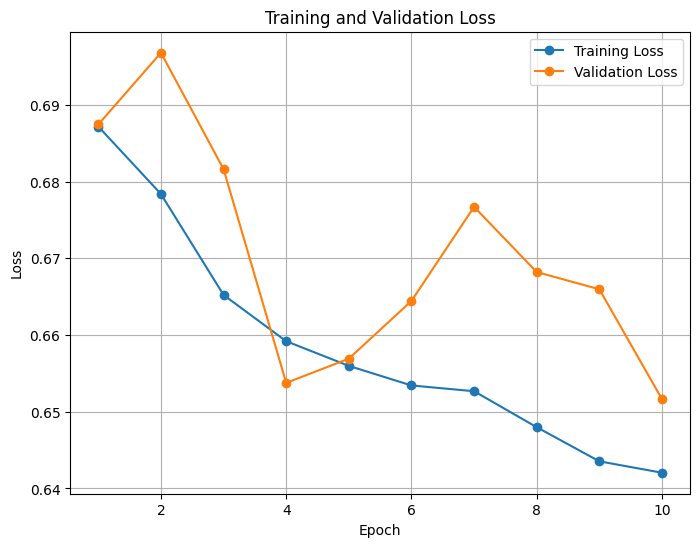

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, NUM_EPOCHS+1), train_losses, label='Training Loss', marker='o')
plt.plot(range(1, NUM_EPOCHS+1), val_losses, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')

In [8]:
torch.save(model.state_dict(), 'cats_dogs_mlp.pth')

In [9]:
def predict_image(image_path, model, transform):
    from PIL import Image
    try:
        model.eval()
        image = Image.open(image_path).convert('L')
        image = transform(image).unsqueeze(0)
        with torch.no_grad():
            output = model(image)
            label = 'Dog' if output.item() >= 0.5 else 'Cat'
            return label, output.item()
    except UnidentifiedImageError:
        print(f"Cannot identify image: {image_path}")
        return None, None

# Example inference (replace 'sample_image.jpg' with your image path)
sample_image_path = 'dog.jpg'
label, prob = predict_image(sample_image_path, model, transform)
if label is not None:
    print(f"Predicted: {label}, Probability: {prob:.4f}")

Predicted: Dog, Probability: 0.7150
